In [1]:
#Import libraries: 
import pandas as pd 
import numpy as np 
from sklearn.ensemble import GradientBoostingClassifier #GBM algorithm 
from sklearn import metrics #Additional scklearn functions 
from sklearn.model_selection import cross_val_score, GridSearchCV #Perforing grid search 
import matplotlib.pylab as plt 
%matplotlib inline 
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 12, 4

In [2]:
df = pd.read_pickle('../input/processed_data.pickle')
df_train = df.dropna(subset=['shot_made_flag'])
df_train.dropna(subset=['MA200'], inplace=True)
df_train.shape

/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(25538, 195)

In [3]:
# adapted from https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
def modelfit(model, df, features, label, scoring='accuracy', performCV=True, printFeatureImportance=True, cv_folds=5):
    ''' 
    parameters
    ----------
        model
        df dataframe
            the dataframe with the training data
        features list
            list of features to keep for training            
        label string
            name of label
        performCV boolean
            True to get a CV score
        printFeatureImportance
            True to plot the features importance
        cv_folds
        
    '''
    
    # fit the algoritm on the data
    model.fit(df[features], df[label])
    
    # predict training set
    df_predictions = model.predict(df[features])
    df_proba = model.predict_proba(df[features])[:,1]
    
    # perform cross-validation
    if performCV:
        cv_score = cross_val_score(model, df[features], df[label], cv=cv_folds, scoring=scoring)
    
    # print report
    print('\nModel Report')
    print('Accuracy: %.4g' % metrics.accuracy_score(df[label].values, df_predictions))
    print('AUC Score (Train): %f' % metrics.roc_auc_score(df[label], df_proba))
    
    if performCV:
        print('CV score (%s): Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g' % (scoring,np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    # Print Feature Importance: 
    if printFeatureImportance: 
        feat_imp = pd.Series(model.feature_importances_, features).sort_values(ascending=False) 
        feat_imp.plot(kind='bar', title='Feature Importances') 
        plt.ylabel('Feature Importance Score')       
              

In [4]:
# choose all features
features = df_train.drop(['shot_id','game_date','shot_made_flag'],axis=1).columns


Model Report
Accuracy: 0.7215
AUC Score (Train): 0.790535
CV score (neg_log_loss): Mean - -0.665513 | Std - 0.05293251 | Min - -0.7118029 | Max - -0.5768661


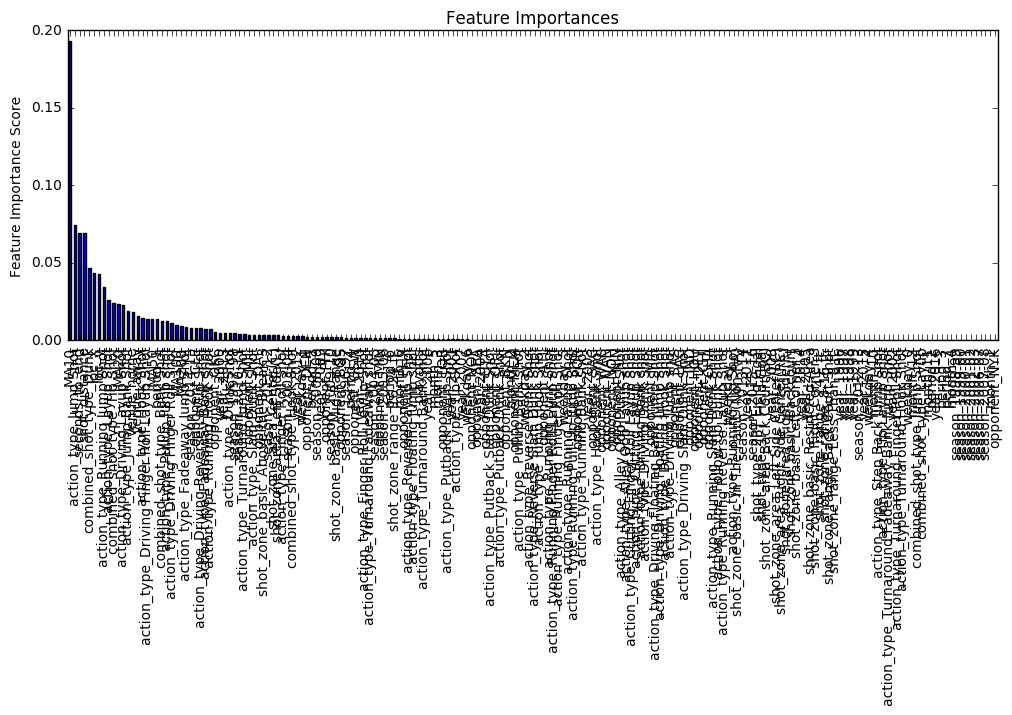

In [5]:
# first, we get a baseline performance
gbm0 = GradientBoostingClassifier(random_state=10) 
modelfit(gbm0, df_train, features, 'shot_made_flag', 'neg_log_loss')

In [6]:
# parameter tuning

learning_rate = 0.1
min_samples_split = 255 # This should be ~0.5-1% of total values.
min_samples_leaf = 50 # Can be selected based on intuition
max_depth = 8 # Should be chosen (5-8) based on the number of observations and predictors.

estimator = GradientBoostingClassifier(learning_rate=learning_rate, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_depth=max_depth,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)

# do a grid search and test out values from 20 to 80 in steps of 10
param_test1 = {'n_estimators':range(20,81,10)}

gsearch1 = GridSearchCV(estimator = estimator,
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch1.fit(df_train[features],df_train['shot_made_flag'])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/home/guillaume/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.74420, std: 0.01750, params: {'n_estimators': 20},
  mean: 0.74192, std: 0.02359, params: {'n_estimators': 30},
  mean: 0.73813, std: 0.03045, params: {'n_estimators': 40},
  mean: 0.73977, std: 0.03093, params: {'n_estimators': 50},
  mean: 0.73807, std: 0.03320, params: {'n_estimators': 60},
  mean: 0.73618, std: 0.03517, params: {'n_estimators': 70},
  mean: 0.73450, std: 0.03658, params: {'n_estimators': 80}],
 {'n_estimators': 20},
 0.7442009092225037)

In [7]:
gsearch1.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=255, min_weight_fraction_leaf=0.0,
              n_estimators=20, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False)

In [8]:
# The number of estimators should range around 40-70
# I run the gridsearch again with a lower learning rate

learning_rate = 0.05
min_samples_split = 255 
min_samples_leaf = 50 
max_depth = 8 

estimator = GradientBoostingClassifier(learning_rate=learning_rate, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_depth=max_depth,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)

# do a grid search and test out values from 20 to 80 in steps of 10
param_test2 = {'n_estimators':range(20,81,10)}

gsearch2 = GridSearchCV(estimator = estimator,
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch2.fit(df_train[features],df_train['shot_made_flag'])
gsearch2.best_params_, gsearch2.best_score_

({'n_estimators': 50}, 0.75060618070578322)

In [9]:
# 50 estimators is a better value. 
# I now can tune tree-specific parameters

learning_rate = 0.05
min_samples_split = 255 
min_samples_leaf = 50 
max_depth = 8 
n_estimators = 50

estimator = GradientBoostingClassifier(learning_rate=learning_rate, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_depth=max_depth,
                                       n_estimators = n_estimators,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)
# tune max_depth and min_samples_split
param_test3 = {'max_depth':range(5,16,2),
               'min_samples_split':range(200,1001,200)}

gsearch3 = GridSearchCV(estimator = estimator,
                        param_grid=param_test3,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=5)

gsearch3.fit(df_train[features],df_train['shot_made_flag'])
gsearch3.best_params_, gsearch3.best_score_

({'max_depth': 13, 'min_samples_split': 800}, 0.75357125964638538)

In [10]:
# tune min_sample_split and min_samples_leaf

learning_rate = 0.05
min_samples_split = 800 # updated from gsearch3
min_samples_leaf = 50  
max_depth = 13 # updated from gsearch3
n_estimators = 50

estimator = GradientBoostingClassifier(learning_rate=learning_rate, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_depth=max_depth,
                                       n_estimators = n_estimators,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)

param_test4 = {'min_samples_split':range(1000,2100,200), 
               'min_samples_leaf':range(30,71,10)}

gsearch4 = GridSearchCV(estimator = estimator, 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch4.fit(df_train[features],df_train['shot_made_flag'])
gsearch4.best_params_, gsearch4.best_score_

({'min_samples_leaf': 70, 'min_samples_split': 1000}, 0.75424273104410777)


Model Report
Accuracy: 0.722
AUC Score (Train): 0.789832
CV score (neg_log_loss): Mean - -0.585982 | Std - 0.01665236 | Min - -0.617421 | Max - -0.5695002


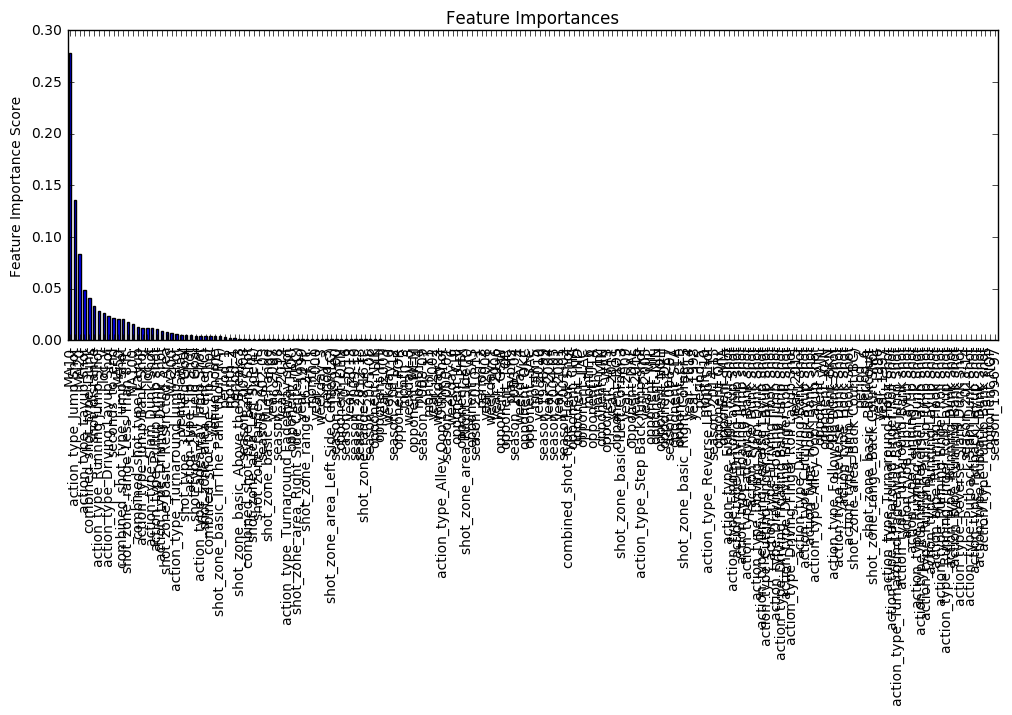

In [11]:
# we fit the model with optimized parameters
modelfit(gsearch4.best_estimator_, df_train, features, 'shot_made_flag', 'neg_log_loss')

In [12]:
# tuning max_features

learning_rate = 0.05
min_samples_split = 1000 # updated from gsearch4
min_samples_leaf = 70 # updated from gsearch4  
max_depth = 13 
n_estimators = 50

estimator = GradientBoostingClassifier(learning_rate=learning_rate, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_depth=max_depth,
                                       n_estimators = n_estimators,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)

param_test5 = {'max_features':range(7,20,2)}

gsearch5 = GridSearchCV(estimator = estimator,
                        param_grid = param_test5, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch5.fit(df_train[features],df_train['shot_made_flag'])
gsearch5.best_params_, gsearch5.best_score_

({'max_features': 13}, 0.75424273104410777)

In [13]:
# tuning subsample

learning_rate = 0.05
min_samples_split = 1000 
min_samples_leaf = 70 
max_depth = 13 
n_estimators = 50
max_features = 13

estimator = GradientBoostingClassifier(learning_rate=learning_rate, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_depth=max_depth,
                                       n_estimators = n_estimators,
                                       max_features = max_features,
                                       subsample=0.8,
                                       random_state=10)

param_test6 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

gsearch6 = GridSearchCV(estimator = estimator,
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch6.fit(df_train[features],df_train['shot_made_flag'])
gsearch6.best_params_, gsearch5.best_score_

({'subsample': 0.7}, 0.75424273104410777)


Model Report
Accuracy: 0.7205
AUC Score (Train): 0.787791
CV score (neg_log_loss): Mean - -0.5850909 | Std - 0.01216674 | Min - -0.6060493 | Max - -0.5716401


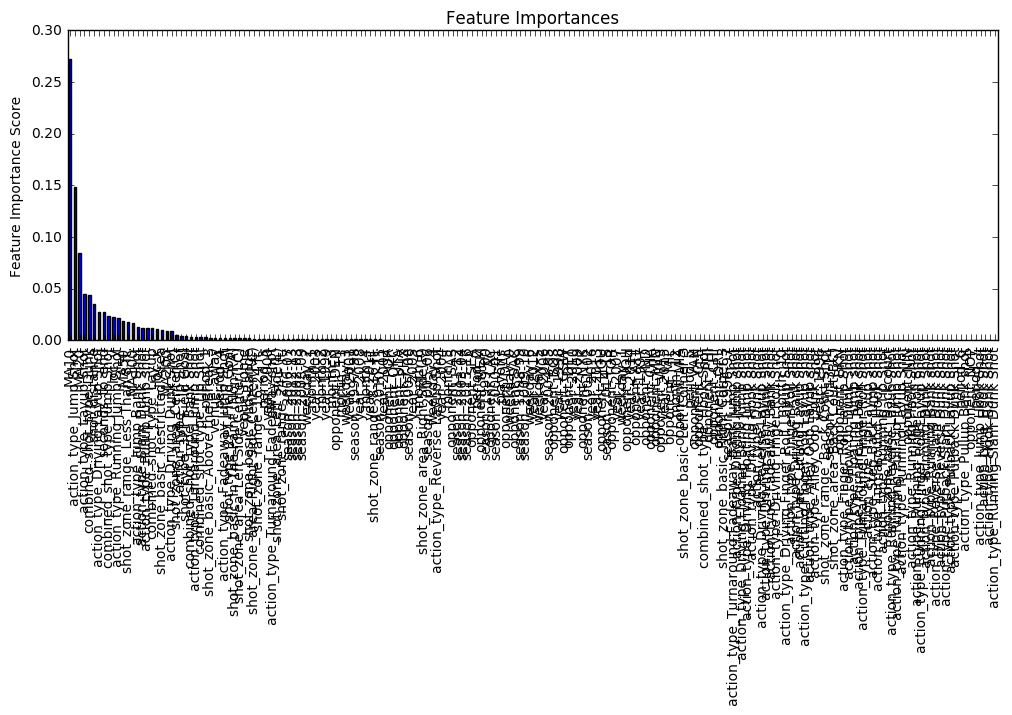

In [14]:
# we fit the model with optimized parameters
modelfit(gsearch6.best_estimator_, df_train, features, 'shot_made_flag', 'neg_log_loss')

In [ ]:
# import the data
df = pd.read_pickle('../input/processed_data.pickle')

# create submission file
gbc = gsearch6.best_estimator_

# keep all features
best_features = features

# We need an index to filter examples prior to the prediction.
# At this point, the dataframe is already sorted chronologically.
# We just need to reset the index
df.reset_index(inplace=True)

# There are some NaN in moving averages features.
# we replace them with 0.4 (the average success rate of kobe)
columns = ['MA10','MA20','MA50','MA100','MA200']

for col in columns:
    df[col].fillna(0.4, inplace=True)
    
# We now split the dataframe into a training set and a test set
df_train = df.dropna(subset=['shot_made_flag'])
df_test = df[df['shot_made_flag'].isnull()]

# We remove the shot_made_flag from the test set
# All values are NaN
df_test.drop(['shot_made_flag'],axis=1,inplace=True)

import time
import csv
import warnings; warnings.simplefilter('ignore')

start = time.time()

i = 1
for index, row in df_test.iterrows():
        
    shot_id = df_test.get_value(index,'shot_id')
    
    print('Prediction # ' + str(i) + ', index = ' + str(index) + ', shot_id = ' + str(shot_id) + ', time = ' + str(time.time() - start))
    i += 1
    
    # create a subset to train the classifier
    train_subset = df_train[df_train.index < index]
    #X = np.array(train_subset.drop(['shot_id','shot_made_flag'], axis=1))
    X = np.array(train_subset[best_features])
    y = np.array(train_subset['shot_made_flag'])
    gbc.fit(X,y)
    
    # make a prediction for row
    X_test = np.array(df_test[best_features].loc[index])
    y_sub = gbc.predict_proba(X_test)    
    
    # save the prediction to a csv file    
    file = '../submissions/2017-02-07-gm-gradient-boosting-01.csv'
    with open(file, 'a') as f:
        writer = csv.writer(f)
        # The second predicted value is the one we want
        # P(shot successful)
        writer.writerow([shot_id,y_sub[0][1]])
        
print('finished in ' + str(time.time() - start) + ' seconds.')

The submission got a score of **0.66689** ranking **734/1117**